In [1]:
# Threading
# To start Julia with 8 threads on PC, open anaconda prompt and run <set JULIA_NUM_THREADS=8>, then run <jupyter notebook>
# ENV["JULIA_NUM_THREADS"] = 8 # Don't need to run on mac - set nthreads in VScode
Threads.nthreads()

8

In [2]:
# import Pkg; Pkg.develop(path="/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl")
using IRQIV
import PyPlot as plt
import Statistics, NaNStatistics
plt.pygui(true) # sets plots to popup instead of inline

true

In [16]:
# Global camera parameters
fl = 1214.2857142857144 # In pixels - from Seth
include(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl")
Camera = IRQIV.FLIR_SC8303_17mm
ι = IRQIV.IntrinsicCalibrationParameters(Camera)

IntrinsicCalibrationParameters(672.5, 392.5, 1.0086485610865155, 1.0, 1.4e-5, [1.0, 3.0, 5.0], [0.020522291524825344, -3.156396095419575e-8, -8.859823756718999e-14])

In [3]:
#### STREAMLINE METHOD 2 - MQD VECTOR FIELD

# Initialize MQD

# Subwindow dimensions remain constant
const M=32 # subwindow dims - horiz, N = vert.
const N=32
# Search radius - variance STIV lines steeper slopes approx 35pix/frame
const rhoI = 38 # how far away to search (+/-) - i=short side, j= long side
const rhoJ = 38 # Set these to visual estimates - plot one pair
MQD_parameters = (M=M, N=N, rhoI=rhoI, rhoJ=rhoJ)

# Set ATS parameters
Img_dims = [784, 1344] # Image dims: 784 x 1344
DtFrames = 1                    # Δt, frames (ATS 3116 is at 10Hz)
data_output_rate_frames = 1    # difference between I1 sequence, frames - time sep of output
nImagePairs = 100 # can set to inf - all frames in file
Nfiles = 40 # Set number of files to average over

# Load IR images:
I1inds = range(1, step=data_output_rate_frames, length=nImagePairs)
I2inds = I1inds .+ DtFrames

# Crop AOI to area just outside sluicegate
right_crop = 900
# Offset distance (horizontal left shift)
offset_distance = 150  # Pixels

subwincorners = CartesianIndices(( (N+rhoI):N:(Img_dims[1]-(N+rhoI+1)),
                                    (M+rhoJ):M:right_crop))

filenum = 3370
FLIR_filename = joinpath("/Volumes/ETH_4TB/CNRD_IR/Rec-DeFreesLab_-00" * string.(filenum) * ".ats")
ats_year = 2022
@assert isfile(FLIR_filename)
I1images = LoadATSImageSequence(FLIR_filename, I1inds, ats_year)
I2images = LoadATSImageSequence(FLIR_filename, I2inds, ats_year)

# Run MQD

# Remove image pairs when at least one image took place during NUC (calibration)
# mode:
if any(isnuc(I1images.Headers)) || any(isnuc(I2images.Headers))
    nuc_frames = isnuc(I1images.Headers) .| isnuc(I2images.Headers)
    I1inds = I1inds[.!( isnuc(I1images.Headers) .| isnuc(I2images.Headers) )]
    I2inds = I2inds[.!( isnuc(I1images.Headers) .| isnuc(I2images.Headers) )]
    I1images = LoadATSImageSequence(FLIR_filename, I1inds, ats_year)
    I2images = LoadATSImageSequence(FLIR_filename, I2inds, ats_year)
end

# Initialize MQD calculation:
MQD_variables = initialize_MQD(I1images,
                            I2images,
                            subwincorners,
                            N, M,
                            rhoI, rhoJ)                              

# Perform the MQD analysis:
subpix_shifts_i, subpix_shifts_j, performance_message = perform_MQD(
    I1images, I2images, subwincorners, MQD_variables)

mean_shifts_i = dropdims(NaNStatistics.nanmean(subpix_shifts_i, dims = 3), dims = 3)
mean_shifts_j = dropdims(NaNStatistics.nanmean(subpix_shifts_j, dims = 3), dims = 3)

# Plotting in pixel space (generate indices for vector locations) - issue w/ CSV package in multithread mode
x_vector = [index[2] for index in subwincorners]
y_vector = [index[1] for index in subwincorners]

1.0%┣▍                                         ┫ 1/100 [00:09<Inf:Inf, InfGs/it]
9.0%┣████▎                                          ┫ 9/100 [00:11<02:00, 1s/it]
17.0%┣███████▋                                     ┫ 17/100 [00:11<00:59, 1it/s]
23.0%┣██████████▍                                  ┫ 23/100 [00:12<00:41, 2it/s]
25.0%┣███████████▎                                 ┫ 25/100 [00:12<00:37, 2it/s]
30.0%┣█████████████▌                               ┫ 30/100 [00:13<00:31, 2it/s]
31.0%┣██████████████                               ┫ 31/100 [00:13<00:30, 2it/s]
32.0%┣██████████████▍                              ┫ 32/100 [00:13<00:29, 2it/s]
34.0%┣███████████████▎                             ┫ 34/100 [00:13<00:27, 2it/s]
39.0%┣█████████████████▌                           ┫ 39/100 [00:14<00:22, 3it/s]
40.0%┣██████████████████                           ┫ 40/100 [00:14<00:21, 3it/s]
41.0%┣██████████████████▌                          ┫ 41/100 [00:14<00:21, 3it/s]
44.0%┣███████████████████▉  

Performance stats (MQD loop only)
time [s]                    25.389035916
subwins/s             2150.5345922013307
allocations [GB]                   18.48
allocations [MB/subwin]               33.85
time [m]                            0.42
total n subwindows                 54600
n image pairs                        100
n subwindows in FOV                  546
size(subwindows)                (21, 26)
M, N                            (32, 32)
rhoI, rhoJ                      (38, 38)
allocations [B]              18482784205
allocations [MB]                18482.78
gc time [s]                  4.030400667
gc stats            Base.GC_Diff(18482784205, 218826, 2, 9157672, 60964, 211253, 4030400667, 17, 0)
number of threads                      8
Running on apple-m1 CPU specs:
Apple M1: 
       speed         user         nice          sys         idle          irq
#1  2400 MHz     539922 s          0 s     653741 s    3615417 s          0 s
#2  2400 MHz     494546 s          0 s     616120 

21×26 Matrix{Int64}:
  70   70   70   70   70   70   70   70  …   70   70   70   70   70   70   70
 102  102  102  102  102  102  102  102     102  102  102  102  102  102  102
 134  134  134  134  134  134  134  134     134  134  134  134  134  134  134
 166  166  166  166  166  166  166  166     166  166  166  166  166  166  166
 198  198  198  198  198  198  198  198     198  198  198  198  198  198  198
 230  230  230  230  230  230  230  230  …  230  230  230  230  230  230  230
 262  262  262  262  262  262  262  262     262  262  262  262  262  262  262
 294  294  294  294  294  294  294  294     294  294  294  294  294  294  294
 326  326  326  326  326  326  326  326     326  326  326  326  326  326  326
 358  358  358  358  358  358  358  358     358  358  358  358  358  358  358
   ⋮                        ⋮            ⋱         ⋮                        ⋮
 454  454  454  454  454  454  454  454     454  454  454  454  454  454  454
 486  486  486  486  486  486  486  486    

In [4]:
# Define initial conditions from which to start numerical integration of vector field

# Convert to tuples and take the first (row) component, then add half the subwindow dimension
vertical_indices = round.(Int, [Tuple(I)[1] for I in subwincorners][1:end-1,1].+(N/2))

us_shadow_start = [182,1] # [u,v]
us_shadow_end = [764,784] # [u,v]
shadow_slope = (us_shadow_end[2] - us_shadow_start[2]) / (us_shadow_end[1] - us_shadow_start[1])

# Find horizontal coordinates along the diagonal line for each vertical index
initial_conditions = []
for v in vertical_indices
    # Horizontal coordinate on the diagonal line at the given vertical coordinate
    col_on_diagonal = us_shadow_start[1] + (v - us_shadow_start[2]) / shadow_slope
    
    # Shift directly left by subtracting the offset distance
    col_shifted = col_on_diagonal + offset_distance
    
    # Add the shifted point as an initial condition
    push!(initial_conditions, (v, round(Int, col_shifted)))
end

initial_conditions
initial_rows, initial_cols = zip(initial_conditions...) |> collect

2-element Vector{NTuple{20, Int64}}:
 (86, 118, 150, 182, 214, 246, 278, 310, 342, 374, 406, 438, 470, 502, 534, 566, 598, 630, 662, 694)
 (395, 419, 443, 467, 490, 514, 538, 562, 585, 609, 633, 657, 681, 704, 728, 752, 776, 800, 823, 847)

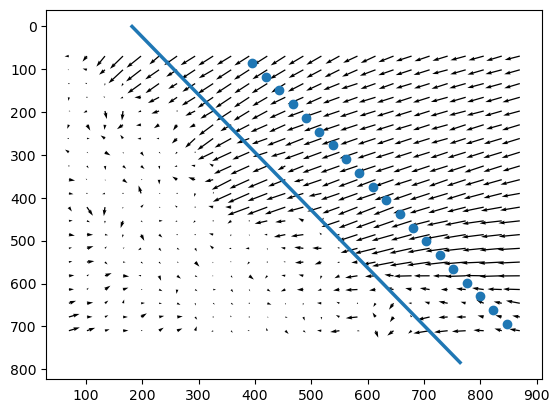

In [5]:
# plt.close("all")
# fig,axs = plt.subplots()
# axs.quiver(x_vector, y_vector, mean_shifts_j[:,:], mean_shifts_i[:,:], angles="xy")
# axs.invert_yaxis()
# plt.plot([us_shadow_start[1], us_shadow_end[1]], [us_shadow_start[2], us_shadow_end[2]], label="Diagonal Line", linewidth=2.5)
# plt.scatter(initial_cols, initial_rows)
# plt.gcf()

In [ ]:
# # Visualize frames - SKIP
# # Create a plot window and display the initial image

# fig, ax = plt.subplots()
# im = ax.imshow(I1images[1], cmap="viridis", vmin=10000, vmax=10100)

# # Function to update the image
# function update_image!(new_img)
#     plt.imshow(new_img, cmap="viridis", vmin=10000, vmax=11000)
#     plt.draw()          # Force an update
#     plt.pause(0.001)
# end

# # Close all existing plot windows (optional, if needed)
# plt.close("all")

# # Update the image in a loop
# for i in 1:length(I1images)
#     img = I1images[i]
#     update_image!(img)
#     plt.title("$i")
# end

# plt.show()

In [ ]:
# Fit streamlines to vector field

import DifferentialEquations
using Interpolations
import StaticArrays

function meshgrid(x::AbstractVector, y::AbstractVector)
    X = repeat(x', length(y), 1)
    Y = repeat(y, 1, length(x))
    return X, Y
end

function vector_field(u, p, t)
    x, y = u
    U = u_interp(x, y)
    V = v_interp(x, y)
    return StaticArrays.SA[U, V]
end

# Termination condition function
function terminate_at_bounds(u, t, integrator)
    x, y = u[2], u[1]
    
    # Check if out of image bounds
    if x < 1 || x > Img_dims[2] || y < 1 || y > Img_dims[1]
        return true
    end
    
    # Check if x is greater than the interpolated x-coordinate of us_shadow
    interpolated_x = shadow_interp(y)
    if x < interpolated_x
        return true
    end
    
    return false
end

# Termination action function
function terminate_action!(integrator)
    DifferentialEquations.terminate!(integrator)
end

# Compute streamline function
function compute_streamline(start_point)
    # Convert the start point to a StaticArray
    start_point_sa = StaticArrays.SA[start_point[1], start_point[2]]

    # Set time span for the ODE solver
    tspan = (0.0, 200.0)  # Adjust the time span as needed

    # Create the DiscreteCallback
    cb = DifferentialEquations.DiscreteCallback(terminate_at_bounds, terminate_action!)

    # Define the ODEProblem with the initial condition and vector field
    prob = DifferentialEquations.ODEProblem(vector_field, start_point_sa, tspan)

    # Solve the ODEProblem with the callback
    sol = DifferentialEquations.solve(prob, DifferentialEquations.Tsit5(), callback=cb)

    # Extract and return the streamline coordinates
    streamline_coords = hcat(sol.u...)'
    # return streamline_coords
    coords = [(sol[1, i], sol[2, i]) for i in 1:length(sol.t)]
    push!(all_streamline_coords, coords)
    print(streamline_coords)
end

# Function definitions - line identification

# Bresenham's line algorithm to get pixels for a line
function bresenham_line(x0, y0, x1, y1)
    pixels = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = x0 < x1 ? 1 : -1
    sy = y0 < y1 ? 1 : -1
    err = dx - dy

    while true
        push!(pixels, (x0, y0))
        if x0 == x1 && y0 == y1
            break
        end
        e2 = 2 * err
        if e2 > -dy
            err -= dy
            x0 += sx
        end
        if e2 < dx
            err += dx
            y0 += sy
        end
    end
    return pixels
end

# Function to determine if a point is beyond the diagonal line
function right_of_diagonal(x, y, x_start, y_start, x_end, y_end)
    # Calculate the cross product to determine the side of the line
    line_value = (x_end - x_start) * (y - y_start) - (y_end - y_start) * (x - x_start)
    return line_value < 0  # Adjust depending on which side you want
end

# Function to calculate the slope of each labeled component if it exceeds the length threshold
function calculate_slope_for_components(labels::AbstractArray{Int}, num_components::Int, length_threshold::Int)
    slopes = Dict{Int, Float64}()
    x_lengths = Dict{Int, Float64}()
    
    for label in 1:num_components
        # Find the coordinates of all pixels in the component
        component_coords = findall(x -> x == label, labels)
        
        # Only consider the component if it exceeds the length threshold
        if length(component_coords) > length_threshold
            # Find the first and last pixel coordinates in the component
            first_pixel = component_coords[1]
            last_pixel = component_coords[end]
            
            # Calculate the slope between the first and last pixel
            x1, y1 = first_pixel[2], first_pixel[1]  # (x1, y1)
            x2, y2 = last_pixel[2], last_pixel[1]    # (x2, y2)
            
            if x2 != x1
                slope = (y2 - y1) / (x2 - x1)
            else
                slope = Inf  # Vertical line (undefined slope)
            end
            
            # Store the slope in a dictionary
            slopes[label] = slope
            x_lengths[label] = x2 - x1
        end
    end
    
    return slopes, x_lengths
end

function float_to_bool(edges::Matrix{Float64}, threshold::Float64)
    return edges .> threshold
end

# Label components function for diagonal relationships (instead of 4 connected)
function label_components_8_connected(edges::AbstractArray{Bool})
    rows, cols = size(edges)
    labels = zeros(Int, rows, cols)
    current_label = 0
    
    function in_bounds(r, c)
        return 1 <= r <= rows && 1 <= c <= cols
    end
    
    function dfs(r, c, label)
        stack = [(r, c)]
        while !isempty(stack)
            cr, cc = pop!(stack)
            if in_bounds(cr, cc) && edges[cr, cc] && labels[cr, cc] == 0
                labels[cr, cc] = label
                # Add all 8 neighbors
                for dr in -1:1, dc in -1:1
                    if !(dr == 0 && dc == 0)  # skip the current pixel itself
                        push!(stack, (cr + dr, cc + dc))
                    end
                end
            end
        end
    end
    
    for r in 1:rows
        for c in 1:cols
            if edges[r, c] && labels[r, c] == 0
                current_label += 1
                dfs(r, c, current_label)
            end
        end
    end
    
    return labels, current_label
end

function calculate_path_length(coords::Vector{Tuple{Float64, Float64}})
    # Ensure there are at least two points to calculate a path
    if length(coords) < 2
        return 0.0
    end
    
    # Initialize path length
    path_length = 0.0
    
    # Loop through consecutive points
    for i in 2:length(coords)
        x1, y1 = coords[i-1]
        x2, y2 = coords[i]
        # Add Euclidean distance between consecutive points
        path_length += sqrt((x2 - x1)^2 + (y2 - y1)^2)
    end
    
    return path_length
end


calculate_path_length (generic function with 1 method)

[86.0 395.0; 88.38048725312075 392.15405634343887; 112.58893769800008 363.48333468199394; 136.71370748192527 335.2747921047364; 162.25344687161066 305.63835056952564; 183.21039023141333 279.0641629409664; 183.21039023141333 279.0641629409664][118.0 419.0; 120.52905357662605 415.93207535209723; 137.19956352926917 395.94463384567075; 155.4872632364006 374.6306303686817; 180.1680976341986 346.29643522139503; 204.68249023052232 316.20894817338984; 204.68249023052232 316.20894817338984][150.0 443.0; 152.43065363514654 439.76599800971974; 169.5725678284822 417.10545472555316; 185.2371373721886 397.2672110080969; 240.33054795155465 331.49616047510256; 240.33054795155465 331.49616047510256][182.0 467.0; 184.15060010856897 463.31104581942026; 198.87410292059494 439.30536828362966; 213.7083510278985 416.640027409526; 234.65006306822096 385.1638517385496; 250.0507960669005 362.7036154611314; 250.0507960669005 362.7036154611314][214.0 490.0; 215.93146755396643 485.94383232497256; 218.0660384675006

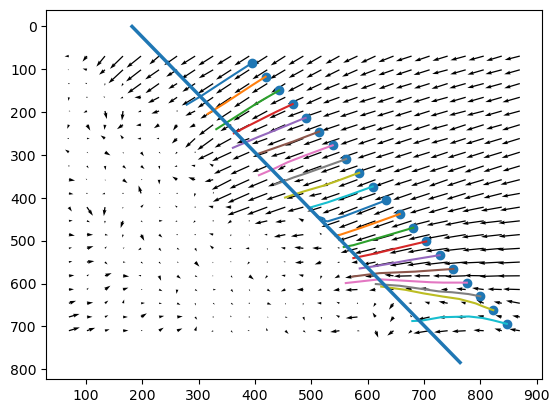

In [8]:
# Ensure data is in Float64 format
i = Float64[y_vector[:,1]...]
j = Float64[x_vector[1,:]...]

# # Check dimensions
# println("Dimensions of i: ", length(i))
# println("Dimensions of j: ", length(j))

# Create linear interpolants for the vector field
u_interp = extrapolate(interpolate((i, j), mean_shifts_i, Gridded(Linear())), Line())
v_interp = extrapolate(interpolate((i, j), mean_shifts_j, Gridded(Linear())), Line())

# Define initial conditions and time span
initial_conditions = [StaticArrays.SA[sp[1], sp[2]] for sp in initial_conditions]

# Store coordinates of all streamlines

shadow_interp = LinearInterpolation(Float64[us_shadow_start[2], us_shadow_end[2]], 
                            Float64[us_shadow_start[1], us_shadow_end[1]]; extrapolation_bc=Line())

# Compute streamlines for all starting points
all_streamline_coords = [] # Initialize default array
for sp in initial_conditions
    compute_streamline(sp)
end

# Plot the vector field using quiver
X, Y = meshgrid(j, i)

fig, ax = plt.subplots()
ax.quiver(X, Y, mean_shifts_j, mean_shifts_i, angles="xy") # Why the ' on U and V?

# Plot all streamlines
for coords in all_streamline_coords
    x_coords = [coord[2] for coord in coords]
    y_coords = [coord[1] for coord in coords]
    ax.plot(x_coords, y_coords)# , label="Streamline")
end

# Set labels and title
ax.invert_yaxis()  # To match the coordinate system of the matrices
# ax.legend()
plt.plot([us_shadow_start[1], us_shadow_end[1]], [us_shadow_start[2], us_shadow_end[2]], label="Diagonal Line", linewidth=2.5)
plt.scatter(initial_cols, initial_rows)

# Show the plot
# plt.gcf()

Shortest streamline is 96 pixels

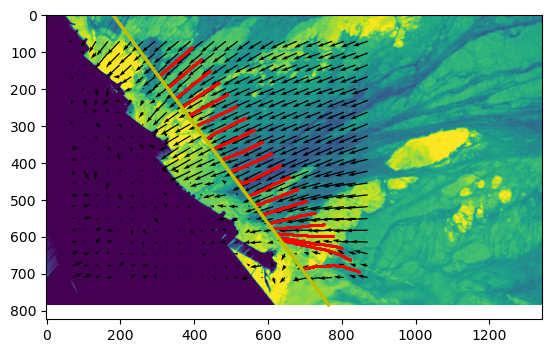

In [10]:
# Convert streamlines to pixel coordinates

# Define a vector of sets, one for each streamline
StreamlinePixelsSingle = []

# Diagonal line endpoints
x_start, y_start = us_shadow_start
x_end, y_end = us_shadow_end

# Set pixel intensity limits for figure
vmin_val = 10200
vmax_val = 10500

# Iterate through each streamline in `all_streamline_coords`
for coords in all_streamline_coords
    # Define a set to store unique pixels for the current streamline
    streamline_pixels = []  # Use an ordered vector instead of a set

    for k in 1:length(coords)-1
        y0, x0 = coords[k]
        y1, x1 = coords[k+1]

        # Calculate Bresenham pixels for the current segment
        bresenham_pixels = bresenham_line(round(Int, y0), round(Int, x0), round(Int, y1), round(Int, x1))
        
        # Filter pixels that are beyond the diagonal line
        filtered_pixels = filter(p -> right_of_diagonal(p[2], p[1], x_start, y_start, x_end, y_end), bresenham_pixels)

        # Add pixels to the current streamline set
        append!(streamline_pixels, filtered_pixels)    
    end
    
    # Add the unique set of pixels for this streamline to the overall list
    push!(StreamlinePixelsSingle, streamline_pixels)
end

streamline_lengths = [length(streamline) for streamline in StreamlinePixelsSingle]
print("Shortest streamline is $(minimum(streamline_lengths)) pixels") # See how long shortest streamline is

# (Optional) Convert sets back to arrays if needed
StreamlinePixelsSingle = [collect(streamline) for streamline in StreamlinePixelsSingle]

# # Plot the vector field using quiver
i = Float64[y_vector[:,1]...]
j = Float64[x_vector[1,:]...]
X, Y = meshgrid(j, i)

# Bresenham line plot
fig, ax = plt.subplots()
plt.imshow(I1images[1], vmin = vmin_val, vmax = vmax_val)#, extent=(left_crop, Img_dims[2], Img_dims[1], 0),cmap="viridis")
# ax.invert_yaxis()  # To match the coordinate system of the matrices
ax.quiver(X, Y, mean_shifts_j, mean_shifts_i, angles="xy")
# Plot all streamlines
# for coords in all_streamline_coords
#     x_coords = [coord[2] for coord in coords]
#     y_coords = [coord[1] for coord in coords]
#     ax.plot(x_coords, y_coords, label="Streamline")
# end


for streamline_pixels in StreamlinePixelsSingle
    for (y, x) in streamline_pixels
        ax.plot(x, y, "ro", markersize=1, label="Streamline Pixels")
    end
end

# Set labels and title
# ax.invert_yaxis()  # To match the coordinate system of the matrices
plt.plot([us_shadow_start[1], us_shadow_end[1]], [us_shadow_start[2], us_shadow_end[2]], label="Diagonal Line", linewidth=2.5, "y")
# plt.scatter(initial_cols, initial_rows, c="y")
# ax.set_title("Vector Field with Streamlines and Bresenham Pixels")
# ax.legend()

# Show the plot
plt.gcf()

In [14]:
# INCORPORATE GEOREFERENCING - river side (same code as bayside)
import CSV, Dates, Geodesy
using DataFrames
ft_to_m = 0.3048

# Import dike resurvey data from May 2023
macpath = raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2023/5_23_SiteVisit/Georeferencing/Leica/M_CNRD.TXT"
winpath = raw"C:\Users\evanh\Box\Cornell\CACO\2023\5_23_SiteVisit\Georeferencing\Leica\M_CNRD.TXT"
ft_to_m = 0.3048
CNRD_resurvey = CSV.read(macpath, DataFrames.DataFrame) # Total station recorded in survey ft!!
US_GCP_xyz_resurvey = [CNRD_resurvey[2:7,2] CNRD_resurvey[2:7,3] CNRD_resurvey[2:7,4]] .* ft_to_m
DS_GCP_xyz_resurvey = [CNRD_resurvey[8:12,2] CNRD_resurvey[8:12,3] CNRD_resurvey[8:12,4]] .* ft_to_m

# Convert to geospatial coords using GPS data
antenna_csv = CSV.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2023/5_23_SiteVisit/Georeferencing/InertialSense/20230515_173251_base/LOG_SN40107_20230515_173251_0001_DID_GPS1_RTK_POS.csv", DataFrames.DataFrame)
antenna_lla = Geodesy.LLA(Statistics.mean(antenna_csv."lla[0]"), Statistics.mean(antenna_csv."lla[1]"), Statistics.mean(antenna_csv."lla[2]"))
antenna_utm = Geodesy.UTMZ(antenna_lla, Geodesy.wgs84)

# US_GCP_utm_resurvey = US_GCP_xyz_resurvey + [antenna_utm.x antenna_utm.y antenna_utm.z]
US_GCP_utm_resurvey = US_GCP_xyz_resurvey .+ [antenna_utm.x antenna_utm.y antenna_utm.z] # Add UTM position of antenna to all relative points in m
DS_GCP_utm_resurvey = DS_GCP_xyz_resurvey .+ [antenna_utm.x antenna_utm.y antenna_utm.z] # Add UTM position of antenna to all relative points in m

# Import thermistor data from field campaign

# ChatGPT function to find nearest thermistor times to each ATS file (for WSE)
function find_nearest_time_indices(irregular_times, regular_times)
    nearest_indices = [argmin(abs.(time .- regular_times)) for time in irregular_times]
    return nearest_indices
end

thermpath = raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/Thermistor/P6_CACO_July_2022_truncated.txt"
therm = CSV.read(thermpath, delim = ',', DataFrame)
thermP = therm[:,2] # water surface elevation from thermistor - in dbar?
# # 360 lines per hour, 8640 lines per day
us_therm_cam_offset = (sqrt(9^2-2^2) + 1/3 + 7) * ft_to_m
ds_therm_cam_offset = 209/12*ft_to_m

therm[!,3] = Dates.Date.(therm[!,3], " dd u YYYY")
therm_datetime = Dates.DateTime.(therm[!,3], therm[!,4])
therm = hcat(therm, therm_datetime)
rename!(therm,[:TemperatureC, :PressureM, :Date, :Time, :DateTime])

# Change thermistor elevation relative to camera
therm_moved_bool = (therm.Time .== Dates.Time("08:12:00", "HH:MM:SS")) .& (therm.Date .== Dates.Date("2022-07-14", "yyyy-mm-dd"))
therm_moved_idx = findall(x->x==1, therm_moved_bool)
thermZ = us_therm_cam_offset.-thermP[1:therm_moved_idx[]] # vertical offset from camera to thermistor - 
thermZ = append!(thermZ, ds_therm_cam_offset.-thermP[therm_moved_idx[]+1:end])

therm = hcat(therm, thermZ)
rename!(therm, :x1 => :WaterDistanceFromCameraM)

plt.close("all")
thermT = string.(therm[:,4])
plt.plot(thermT[6302:6302+8638], thermP[6302:6302+8638])
plt.xticks(1:1200:length(thermZ[6302:6302+8638])#, rotation = 45
)
plt.xlabel("Time - July 14, 2022")
plt.ylabel("Thermistor pressure head (m)")
plt.rc("font",size=24)
# plt.gcf()

┌ Warning: thread = 1 warning: parsed expected 6 columns, but didn't reach end of line around data row: 1. Parsing extra columns and widening final columnset
└ @ CSV /Users/evanheberlein/.julia/packages/CSV/OnldF/src/file.jl:578


┌ Warning: Too few BHPHeaders to calculate fps!
└ @ IRQIV.FLIRATSFiles /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/src/FLIRATSFiles.jl:415
┌ Warning: Too few BHPHeaders to calculate fps!
└ @ IRQIV.FLIRATSFiles /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/src/FLIRATSFiles.jl:415
┌ Info: (411768.0031563245, 411770.4443634363)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.9834967245, 411770.2188593963)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.55823976453, 411769.8969740929)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.4251945645, 411769.8061492483)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411766.9903059

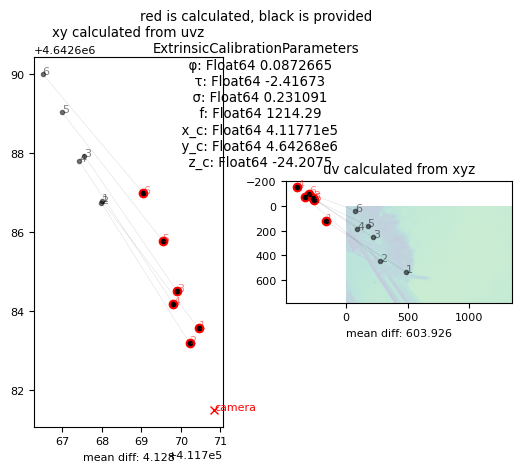

In [18]:
# Camera location calibration setup - RIVER SIDE:
camll_us = [41.931168, -70.064190] # Guess from google maps
camelev_us = sqrt(9^2-2^2)*ft_to_m + (US_GCP_utm_resurvey[1,3]) # add elevation from bridge deck to elevation of first bolt below deck (~4" off?), remove second ft_to_m 12/3/24
cam_LLA_us = Geodesy.LLA(camll_us[1], camll_us[2], camelev_us)
cam_UTM_us = Geodesy.UTMZ(cam_LLA_us, Geodesy.wgs84)

# Camera angle approximation:
azimuth_us = deg2rad(5) # Guess from google maps
# azimuth_us = deg2rad(5-40) # CONVERGE #1
# tilt_us = atan(70/62) # Approx. from photo
# tilt_us = atan(70/62 - deg2rad(55)) # CONVERGE #1
tilt_us = -pi/2 - atan(70/62) # updated 12/3/24 - negative from vertical
roll_us = atan(20/85) # Approx. from photo
# roll_us = atan(20/85 + deg2rad(45)) # CONVERGE #1

# Initial guess of camera's extrinsic parameters:
χinitial_us = IRQIV.ExtrinsicCalibrationParameters(azimuth_us, tilt_us, roll_us, fl, cam_UTM_us.x, cam_UTM_us.y, cam_UTM_us.z) # can also play with height
# χinitial = IRQIV.ExtrinsicCalibrationParameters(azimuth_us, tilt_us, roll_us, fl, cam_UTM_us.x-1, cam_UTM_us.y+2, cam_UTM_us.z) # CONVERGE #1

# UTM coordinates of GCPs:
# TrueGCPxyz = [GCPxyz_us[:,1] GCPxyz_us[:,2] GCPzg_us]

# Pixel coordinates of GCPs, before accounting for radial distortion:
DistortedImageGCPuv_us  = [481 535 # 1L
                        270 446 # 1H
                        215 253 # 2L
                        94 188 # 2H
                        174 159 # 3
                        83 43] # 4
                        #474 65] # board o1

## Remove radial distortion from GCP target coordinates:
TrueGCPuv_us = hcat(IRQIV.RemoveRadialDistortion(DistortedImageGCPuv_us[:,1], DistortedImageGCPuv_us[:,2], Camera)...)

# Optionally, load an IR image and plot it in the background:
FLIR_filename_us = raw"/Volumes/ETH_4TB/CNRD_IR/Rec-DeFreesLab_-003310.ats"
IRimages_us = LoadATSImageSequence(FLIR_filename_us, 1, 2022)
plt.close("all")
plt.rc("font", size=8)
GraphicallyExploreInitialCalibrationGuess(TrueGCPuv_us, US_GCP_utm_resurvey, χinitial_us, ι, IRimages_us[1])
# plt.gcf()

Finished extrinsic calibration:, 16 iterations, max(|ε|)=5e-10, rms(ε₁-ε₀)=6e-11


┌ Info: Initial guess, χinitial:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:15


ExtrinsicCalibrationParameters
  φ: Float64 0.08726646259971647
  τ: Float64 -2.416726509974452
  σ: Float64 0.23109066719589708
  f: Float64 1214.2857142857144
  x_c: Float64 411770.8466259552
  y_c: Float64 4.6426814979640795e6
  z_c: Float64 -24.207543132360424
dump(χinitial_us) = nothing
ExtrinsicCalibrationParameters
  φ: Float64 -0.20482039987361095
  τ: Float64 -2.663588777346602
  σ: Float64 0.5576101617172943
  f: Float64 921.7624007662248
  x_c: Float64 411769.0569816039
  y_c: Float64 4.642685635728899e6
  z_c: Float64 -24.21088685609575
dump(χcalculated_us) = nothing
φ diff (degrees) -  16.73534447093977
τ diff (degrees) -  14.144166041454277
σ diff (degrees) -  -18.708188964821062
f diff -  292.52331351948965
x_c diff (meters) -  1.7896443512872793
y_c diff (meters) -  -4.137764819897711
z_c diff (meters) -  0.0033437237353268756


┌ Info: Calibrated values, χcalculated:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:18
┌ Info: Difference between calibrated value and initial guess:
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/CACO_git/CACO_22_jl/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:22


  0.001781 seconds (3.83 k allocations: 389.375 KiB)


┌ Info: (411768.0031563245, 411768.06524219736)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.9834967245, 411767.9677770917)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.55823976453, 411767.515936227)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411767.4251945645, 411767.5068939898)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411766.9903059245, 411767.0305664914)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (411766.4980234445, 411766.4979707668)
└ @ Main /Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl/examples/CameraCalibrationHelpers.jl:68
┌ Info: (484.53052958

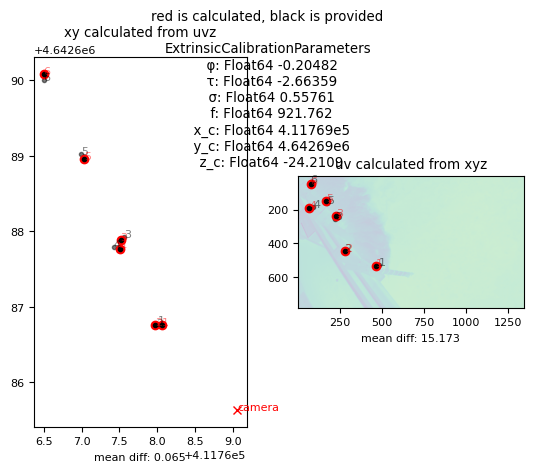

In [27]:
# Camera location calibration - RIVER SIDE:
dlt_us = IRQIV.DLT(χinitial_us, FLIR_SC8303_17mm)
###############################################################################

TrueGCPxyz_us = US_GCP_utm_resurvey # US_GCP_utm_combined

χcalculated_us = ExtrinsicCalibration(
    TrueGCPuv_us,
    TrueGCPxyz_us,
    χinitial_us,
    ι,
    MaxIterations = 50,
    PrintoutStats=true)
# ###############################################################################
@info "Initial guess, χinitial:"
@show dump(χinitial_us)
# 
@info "Calibrated values, χcalculated:"
@show dump(χcalculated_us)
# 
# Describe how much the calibration changed each parameter:
@info "Difference between calibrated value and initial guess:"
for (i,x) in enumerate(fieldnames(typeof(χcalculated_us)))
    if i <= 3
        println("$x diff (degrees) -  $(rad2deg(getfield(χinitial_us, x) - getfield(χcalculated_us, x)))")
    elseif i == 4
        println("$x diff -  $(getfield(χinitial_us, x) - getfield(χcalculated_us, x))")
    else
        println("$x diff (meters) -  $(getfield(χinitial_us, x) - getfield(χcalculated_us, x))")
    end
end

# Extract WSE from thermistor time series using ATS file timestamp
ATS_file_time_us = IRQIV.ats_ts(IRimages_us)
therminds_us = find_nearest_time_indices(ATS_file_time_us, therm.DateTime)
WSE_mean_ATS_us = χcalculated_us.z_c - therm.WaterDistanceFromCameraM[therminds_us][1]
RectParams_us = IRQIV.ImageRectification.calculate_image_rectification(Camera.pixel_resolution, ι, χcalculated_us, WSE_mean_ATS_us, interpolated_grid_spacing=0.1)
rectified_image_us = RectParams_us(IRimages_us)
dlt_calculated = IRQIV.DLT(χcalculated_us, FLIR_SC8303_17mm)

plt.close("all")
plt.rc("font", size=8)
GraphicallyExploreInitialCalibrationGuess(TrueGCPuv_us, TrueGCPxyz_us, χcalculated_us, ι, IRimages_us[1])
plt.gcf()

Geotransform: [411731.1838, 0.15015076923076637, 0.0, 4.6426986079e6, 0.0, -0.14986969697091615]
Projection: PROJCS["NAD83(2011) / UTM zone 19N",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","6318"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6348"]]


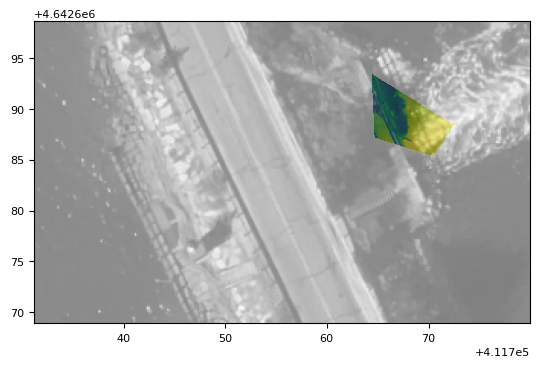

In [21]:
# Test reprojection against basemap imagery

import ArchGDAL
basemap_path = ArchGDAL.read(raw"/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/CACO/2022/Analysis/ESRI_basemap/ESRI_basemap.tif")
basemap_band = ArchGDAL.getband(basemap_path, 1)
basemap = ArchGDAL.read(basemap_band)
# basemap = reverse(reverse(basemap, dims=1), dims=2)
basemap = permutedims(basemap, (2, 1))
# basemap = reverse(reverse(basemap, dims=2))

# Get the geotransform (affine transformation to map pixel coordinates to world coordinates)
geotransform = ArchGDAL.getgeotransform(basemap_path)

# Get the dimensions of the image
width = ArchGDAL.width(basemap_path)
height = ArchGDAL.height(basemap_path)

# Extract the geotransform values
x_min = geotransform[1]
y_max = geotransform[4]
x_res = geotransform[2]  # Pixel width
y_res = geotransform[6]  # Pixel height (negative)

# Calculate the extents
x_max = x_min + size(basemap, 2) * x_res
y_min = y_max + size(basemap, 1) * y_res

# Extent for imshow
basemap_extent = (x_min, x_max, y_min, y_max)

# Get the projection (coordinate system)
projection = ArchGDAL.getproj(basemap_path)

println("Geotransform: ", geotransform)
println("Projection: ", projection)

plt.close("all")
plt.imshow(rectified_image_us, extent=RectParams_us.extent)
plt.imshow(basemap, extent=basemap_extent, alpha = 0.5, cmap = "gray")
plt.gcf()

In [31]:
import Images, ImageEdgeDetection
using ImageEdgeDetection: Percentile
import Dates

filter_rad = 25 # Filter radius for canny algorithm
STIV_line_threshold=50 # How long of lines will have their slopes calculated
alg = ImageEdgeDetection.Canny(spatial_scale=filter_rad, high=Percentile(80), low=Percentile(20))

plt.close("all")

# Loop through all intersecting streamlines and calculate STIV slope

# Preallocate for storing slopes
STIV_averages = zeros(length(StreamlinePixelsSingle))
x_length_averages = zeros(length(StreamlinePixelsSingle))

STIV_time_vec = Dates.Time.(IRQIV.ats_ts(I1images))

ATS_file_time = IRQIV.ats_ts(I1images)
therminds = find_nearest_time_indices(ATS_file_time, therm.DateTime)
WSE_mean_ATS = χcalculated_us.z_c - therm.WaterDistanceFromCameraM[therminds[1]]

STIV_vels = zeros(length(StreamlinePixelsSingle))

# Loop through each streamline
for (stream_ind, streamline_uv) in enumerate(StreamlinePixelsSingle)
    # Locate the intersection index for trimming
    STIV_vec = zeros(length(streamline_uv), length(I1images))
    
    # Extract pixel values for the trimmed streamline across the image time series
    for img = 1:size(I1images, 3)
        for coord = 1:length(streamline_uv)
            i, j = streamline_uv[coord]
            STIV_vec[coord, img] = I1images[i, j, img] # (i, j) for row, col order
        end
    end

    # Assemble STIV pseudoimage
    for row = 1:size(STIV_vec, 1)
        STIV_vec[row, :] = STIV_vec[row, :] .- Statistics.mean(STIV_vec[row, :])
    end

    # Perform edge detection on the STIV image
    STIV_edges = ImageEdgeDetection.detect_edges(STIV_vec, alg)
    STIV_edges = float_to_bool(STIV_edges, 0.5)

    # Label connected components in the detected edges
    STIV_labels, num_components = label_components_8_connected(STIV_edges)

    # Calculate slope for components over a length threshold (e.g. 100 pixels)
    slopes, lengths = calculate_slope_for_components(STIV_labels, num_components, STIV_line_threshold)
    filtered_slopes_lengths = Dict(k => (slope, lengths[k]) for (k, slope) in slopes if slope != 0 && isfinite(slope))

    # Filter out detected slopes of 0 or Inf
    STIV_slopes = Dict(k => v[1] for (k, v) in filtered_slopes_lengths)
    # Calculate size of slopes in x dimension using updated slope calc function
    x_lengths = Dict(k => v[2] for (k, v) in filtered_slopes_lengths)

    STIV_averages[stream_ind] = NaNStatistics.nanmean(collect(values(STIV_slopes))) # Stored as a dictionary
    x_length_averages[stream_ind] = NaNStatistics.nanmean(collect(values(x_lengths)))

     # Calculate physical locations of STIV lines
    xy_coords = fill((0.0, 0.0), length(streamline_uv))
    for (coord_ind, coord) in enumerate(streamline_uv)
        v_ind, u_ind = coord
        x_coord, y_coord = IRQIV.uvz2xy(u_ind, v_ind, WSE_mean_ATS, dlt_calculated)
        xy_coords[coord_ind] = (x_coord, y_coord)
    end

    # Calculate STIV velocities in physical units 
    STIV_time_average = 1/I1images.Metadata.Estimatedfps * x_length_averages[stream_ind] # Seconds per frame * num of frames
    STIV_vels[stream_ind] = calculate_path_length(xy_coords)/STIV_time_average

    # Plot the results
    u_coords = [coord[2] for coord in streamline_uv]  # x = col index
    v_coords = [coord[1] for coord in streamline_uv]  # y = row index
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image with the streamline
    im1 = ax1.imshow(I1images[:,:,1], cmap="viridis", vmin = vmin_val, vmax = vmax_val)  # Show the first frame or another reference image
    ax1.plot(u_coords, v_coords, "r", linewidth=2.5)  # Overlay the streamline in red
    ax1.set_title("Streamline")
    ax1.set_xlabel("U coordinate (pix)")
    ax1.set_ylabel("V coordinate (pix)")
    
    # Plot the STIV image
    im2 = ax2.imshow(STIV_vec, cmap="viridis")  # Display STIV vector
    ax2.set_title("STIV Image")
    ax2.set_xticks(collect(1:30:nImagePairs))
    ax2.set_xticklabels(string.(STIV_time_vec[1:30:nImagePairs]))
    ax2.set_xlabel("Time on 7/14/22")
    ax2.set_ylabel("Distance (pix)")
    
    # Plot the labeled components (slope map)
    im3 = ax3.imshow(STIV_labels, cmap="nipy_spectral")
    ax3.set_title("Labeled Slopes")
    fig.colorbar(im3, ax=ax3, label="Component Label")
    ax3.set_xlabel("Timestep (pix)")
    ax3.set_ylabel("Distance (pix)")

    fig.suptitle("STIV Average Slope: $(round(STIV_averages[stream_ind], digits = 3)) pixels", fontsize=14)
end

STIV_vels

# plt.show()

20-element Vector{Float64}:
 2.6494699072597503
 2.1590960298215145
 3.961373496751739
 2.415848062198705
 3.540313144933253
 2.5338335608716602
 2.590698872572126
 1.8911322269420978
 1.9723082756492725
 2.1471405778073054
 2.5872273711687757
 3.229236488176158
 1.6971524486908465
 2.206216238147465
 1.8996862100240162
 1.9271526088942772
 2.3603642446941646
 1.9162270442450764
 2.654836634149017
 2.6935050918897305

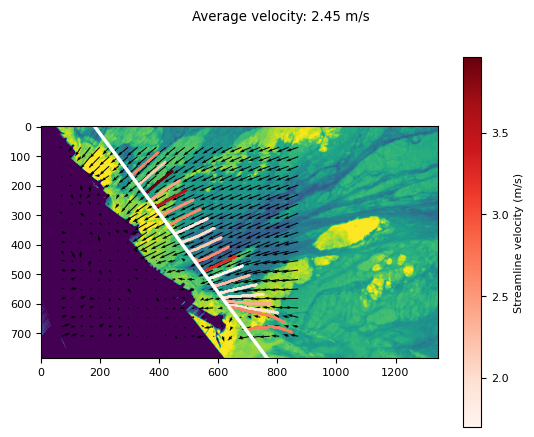

In [33]:
using PyCall
normalize = pyimport("matplotlib.colors").Normalize

min_vel = minimum(STIV_vels)
max_vel = maximum(STIV_vels)
cmap = plt.get_cmap("Reds")  # Choose a colormap (e.g., "viridis")

fig, ax = plt.subplots()
plt.imshow(I1images[1], vmin = vmin_val, vmax = vmax_val)#, extent=(left_crop, Img_dims[2], Img_dims[1], 0),cmap="viridis")
ax.quiver(X, Y, mean_shifts_j, mean_shifts_i, angles="xy")

for (i, streamline_pixels) in enumerate(StreamlinePixelsSingle)
    velocity = STIV_vels[i]
    streamline_color = cmap((velocity - min_vel) / (max_vel - min_vel))  # Map to 0–1 range for the colormap
    # dump((velocity - min_vel) / (max_vel - min_vel))
    for (y, x) in streamline_pixels
        ax.plot(x, y, marker="o", color=streamline_color, markersize=.5, label="Streamline Pixels")
    end
end

# Set labels and title
plt.plot([us_shadow_start[1], us_shadow_end[1]], [us_shadow_start[2], us_shadow_end[2]-1], label="Diagonal Line", linewidth=2.5, "w")

# Add a colorbar
norm = normalize(vmin=min_vel, vmax=max_vel)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Streamline velocity (m/s)")
fig.suptitle("Average velocity: $(round(mean(STIV_vels), digits = 2)) m/s")

plt.gcf()

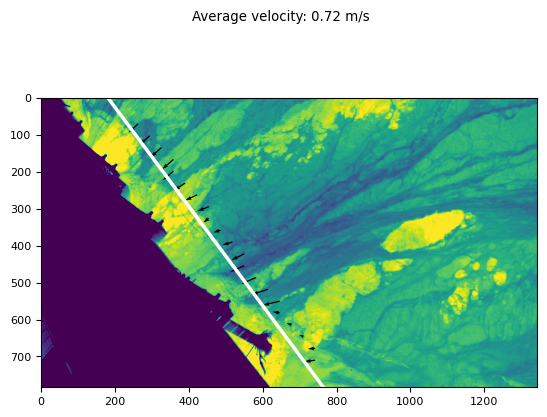

In [43]:
# Compare with normal component of MQD vectors

# Calculate physical dimensions of vector field
displacement_x, displacement_y, centroid_x_origin, centroid_y_origin = pixel2physical_displacements(subwincorners, 
                                                                                                        mean_shifts_i, 
                                                                                                        mean_shifts_j, 
                                                                                                        M, N, 
                                                                                                        WSE_mean_ATS,
                                                                                                        dlt_calculated)


us_transect_start_u = us_shadow_start[1] + M + rhoJ # subtract here bc shadow on rhs of image - us it was on lhs
us_transect_start_v = us_shadow_start[2] + N + rhoI # First point in vertical pixels - edge of image + search radius + subwindow size
# [ds_transect_start_u, ds_transect_start_v]
us_transect_end_v = us_shadow_end[2] - N - rhoI

# Find angle of shadow theta
us_shadow_theta = atan(1/shadow_slope)

# Select subwindows for quantification
subwin_inds_vec = hcat(vec(getindex.(subwincorners,2)), vec(getindex.(subwincorners,1))) # [u, v]

# Filter by row in v coordinate :
subwin_v_coords = getindex.(subwincorners,1)[:,1] # vector of subwindow v pixel coordinates (vertical)
subwin_u_coords = getindex.(subwincorners,2)[1,:] # vector of subwindow u pixel coordinates (horizontal)

subwin_diag_u_inds = zeros(1:length(subwin_v_coords))
subwin_diag_u_inds[1] = findfirst(subwin_u_coords .>= us_transect_start_u) # index in horiz of last subwindow located <= from transect start at top of image

# find u coordinate for each subwindow along diagonal to have one subwindow in each row of v
subwin_diag_u = subwin_u_coords[Int(subwin_diag_u_inds[1])] # find starting u coordinate

for i = 2:length(subwin_v_coords) # for every row in v 
    subwin_diag_u = subwin_diag_u + N/shadow_slope # from previous u coordinate, go 
    subwin_diag_u_inds[i] = findfirst(subwin_u_coords .>= subwin_diag_u)
end

subwin_diag_u_inds
subwin_diag_v_inds = vec(1:length(subwin_v_coords))

# Create mask to isolate indices of subwindows of interest
subwin_mask = zeros(size(subwincorners))
replace!(subwin_mask, 0=>NaN)

for u = 1:size(subwin_mask,2)
    for v = 1:size(subwin_mask,1)
        u_ind = subwin_diag_u_inds[v] # 15
        v_ind = subwin_diag_v_inds[v]
        if u == u_ind && v == v_ind # find subwindow indices in 2d arrays
            subwin_mask[v,u] = 1
        else
        end
    end
end

displacement_x_masked = displacement_x .* subwin_mask
displacement_y_masked = displacement_y .* subwin_mask
inst_disp = hypot.(displacement_x_masked, displacement_y_masked)
inst_disp_alpha = atan.(displacement_y_masked./displacement_x_masked)
inst_disp_field_normal = inst_disp .* cos.(inst_disp_alpha .- us_shadow_theta)

dt = 1/I1images.Metadata.Estimatedfps
normal_vel_profile = NaNStatistics.nanmean(inst_disp_field_normal, dims = (2)) ./ dt

mean_shifts_i_masked = mean_shifts_i .* subwin_mask
mean_shifts_j_masked = mean_shifts_j .* subwin_mask
fig, ax = plt.subplots()
plt.imshow(I1images[1], vmin = vmin_val, vmax = vmax_val)#, extent=(left_crop, Img_dims[2], Img_dims[1], 0),cmap="viridis")
ax.quiver(X, Y, mean_shifts_j_masked, mean_shifts_i_masked, angles="xy")
plt.plot([us_shadow_start[1], us_shadow_end[1]], [us_shadow_start[2], us_shadow_end[2]-1], label="Diagonal Line", linewidth=2.5, "w")
fig.suptitle("Average velocity: $(round(mean(normal_vel_profile), digits = 2)) m/s")
plt.gcf()